In [1]:
import warnings
warnings.filterwarnings('ignore') # Filter out warnings
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from scipy import stats
import math
from math import isnan
# loading machine learning required packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import time
# for multi-class logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
## counter
from collections import Counter

C:\Users\Aaron\Anaconda3\envs\data-x\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Aaron\Anaconda3\envs\data-x\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
file_path_1 = "Messages_allDay_AMZN_withY.csv"
file_path_2 = "Messages_allDay_GOOG_withY.csv"
file_path_3 = "Messages_allDay_AAPL_withY.csv"
df_AMZN = pd.read_csv(file_path_1)
df_GOOG = pd.read_csv(file_path_2)
df_AAPL = pd.read_csv(file_path_3)
# drop useless columns
df_AMZN = df_AMZN.drop(columns=['Unnamed: 0'])
df_GOOG = df_GOOG.drop(columns=['Unnamed: 0'])
df_AAPL = df_AAPL.drop(columns=['Unnamed: 0'])
# stack them to a dictionary
Stocks = {'AMZN':df_AMZN,'GOOG':df_GOOG,'AAPL':df_AAPL}

In [3]:
df_AMZN.head(5)

,Time_stamp,Type,OrderID,V,Dir,Time,V_ask_1,V_bid_1,V_ask_2,V_bid_2,...,mid-price 2_,bid-ask spread 3_,mid-price 3_,bid-ask spread 4_,mid-price 4_,bid-ask spread 5_,mid-price 5_,Mid_price,MidPrice_Moves,SpdCros_Moves
0,34200.18961,1,11885113,21,1,30:00.2,100,21,100,100,...,223.585,0.93,223.535,1.21,223.645,1.40,223.700,223.88,2,2
1,34200.18961,1,3911376,20,-1,30:00.2,100,21,20,100,...,223.570,0.92,223.530,0.96,223.520,1.25,223.625,223.88,2,2
2,34200.18961,1,11534792,100,1,30:00.2,100,21,20,100,...,223.855,0.81,223.585,0.93,223.535,1.21,223.645,223.88,2,2
3,34200.18961,1,1365373,13,-1,30:00.2,100,21,20,100,...,223.855,0.81,223.585,0.93,223.535,1.21,223.645,223.88,2,2
4,34200.18961,1,11474176,2,1,30:00.2,100,21,20,100,...,223.855,0.34,223.820,0.82,223.590,1.18,223.660,223.88,2,2


In [4]:
df_AMZN.columns

Index(['Time_stamp', 'Type', 'OrderID', 'V', 'Dir', 'Time', 'V_ask_1',
       'V_bid_1', 'V_ask_2', 'V_bid_2', 'V_ask_3', 'V_bid_3', 'V_ask_4',
       'V_bid_4', 'V_ask_5', 'V_bid_5', 'Label', 'Level', 'Mean_V_ask',
       'Mean_V_bid', 'V_accu', 'P_', 'P_ask_1_', 'P_bid_1_', 'P_ask_2_',
       'P_bid_2_', 'P_ask_3_', 'P_bid_3_', 'P_ask_4_', 'P_bid_4_', 'P_ask_5_',
       'P_bid_5_', 'bid-ask spread 1_', 'mid-price 1_', 'd_P_ask_51_',
       'd_P_bid_51_', 'd_P_ask_21_', 'd_P_bid_21_', 'd_P_ask_32_',
       'd_P_bid_32_', 'd_P_ask_43_', 'd_P_bid_43_', 'd_P_ask_54_',
       'd_P_bid_54_', 'Mean_P_ask_', 'Mean_P_bid_', 'P_accu_',
       'bid-ask spread 2_', 'mid-price 2_', 'bid-ask spread 3_',
       'mid-price 3_', 'bid-ask spread 4_', 'mid-price 4_',
       'bid-ask spread 5_', 'mid-price 5_', 'Mid_price', 'MidPrice_Moves',
       'SpdCros_Moves'],
      dtype='object')

### loop through all hours in the trading day, plot accuracy, with a lot shortened training set.

In [12]:
def PredictY_balancedTrainingSet(tradingDay_df,trainingTime_mins,nEvents,target_Y,C_param):
     ## return two things:
    train_accs, test_accs = [], []
    # make a copy of the dataframe
    df = tradingDay_df.copy(deep=False)
    st_time,ed_time  = int(list(df['Time_stamp'])[0]), int(list(df['Time_stamp'])[-1])  # in seconds
    ## st: denote the start time of each training session; lag: how much time allowed to fetch from the future
    lag = 5
    st, ed = st_time, st_time + trainingTime_mins*60
    # when last prediction time is not beyond the total trading time window
    while (ed+lag*60<=ed_time):
        # 1) original training set
        train = df[(df['Time_stamp']>=st)&(df['Time_stamp']<ed)]
        # extract observations in training set, where y = 0/1/2
        train_y0 = train[(train[target_Y]==0)]
        train_y1 = train[(train[target_Y]==1)]
        train_y2 = train[(train[target_Y]==2)]
        # want to keep y0:y1:y2 = 1:1:2
        avg_y0y1 = int(float(train_y0.shape[0] + train_y1.shape[1])/2)
        train_y2_new = train_y2.sample(avg_y0y1*2)
        # concat the dataframe to make a new training set
        train_new = pd.concat([train_y0,train_y1,train_y2_new])
        # 2) use next nEvents to define testing set
        test = df.iloc[train.shape[0]:train.shape[0]+nEvents]
        # 3) extract x and y variables in training set and testing set
        Xtrain = np.array(train_new[train_new.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytrain = np.array(train_new[[target_Y]])
        Xtest = np.array(test[test.columns.difference
                                    (['OrderID','Time','Time_stamp','MidPrice_Moves','SpdCros_Moves','Label'])])
        ytest = np.array(test[[target_Y]])
        # train a model
        lr = LogisticRegression(penalty='l2',C=C_param,random_state=0)
        lr.fit(Xtrain,ytrain)
        # Report training accuracy, testing accuracy 
        training_accuracy = lr.score(Xtrain,ytrain)
        testing_accuracy = lr.score(Xtest,ytest)
        test_accs.append(testing_accuracy)
        ### moving the training session forward
        st += trainingTime_mins * 60
        ed += trainingTime_mins * 60
    return test_accs

In [15]:
times_st = ['9:30','9:50','10:10','10:30','10:50','11:10','11:30','11:50','12:10','12:30','12:50',
        '1:10','1:30','1:50','2:10','2:30','2:50','3:10','3:30']
times = []
for i in range(len(times_st)):
    if i != len(times_st)-1:
        times.append(times_st[i]+'-'+times_st[i+1])
    else:
        times.append(times_st[i]+'-'+'3:50')

In [20]:
### Multiclass Logistic Regression 
t = time.time()
# check and drop nan values if necessary
if df_AMZN.isnull().values.any():
    df_AMZN = df_AMZN.dropna()
##### testing 1st one, with cancellation information
test_accs_AMZN = PredictY_balancedTrainingSet(df_AMZN,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 5.45 seconds.


In [21]:
t = time.time()
# check and drop nan values if necessary
if df_GOOG.isnull().values.any():
    df_GOOG = df_GOOG.dropna()
##### testing 1st one, with cancellation information
test_accs_GOOG = PredictY_balancedTrainingSet(df_GOOG,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 6.08 seconds.


In [22]:
t = time.time()
# check and drop nan values if necessary
if df_AAPL.isnull().values.any():
    df_AAPL = df_AAPL.dropna()
##### testing 1st one, with cancellation information
test_accs_AAPL = PredictY_balancedTrainingSet(df_AAPL,20,nEvents=50,target_Y='MidPrice_Moves',C_param=0.1)
print('processing time is {0:.2f} seconds.'.format(time.time()-t))

processing time is 25.36 seconds.


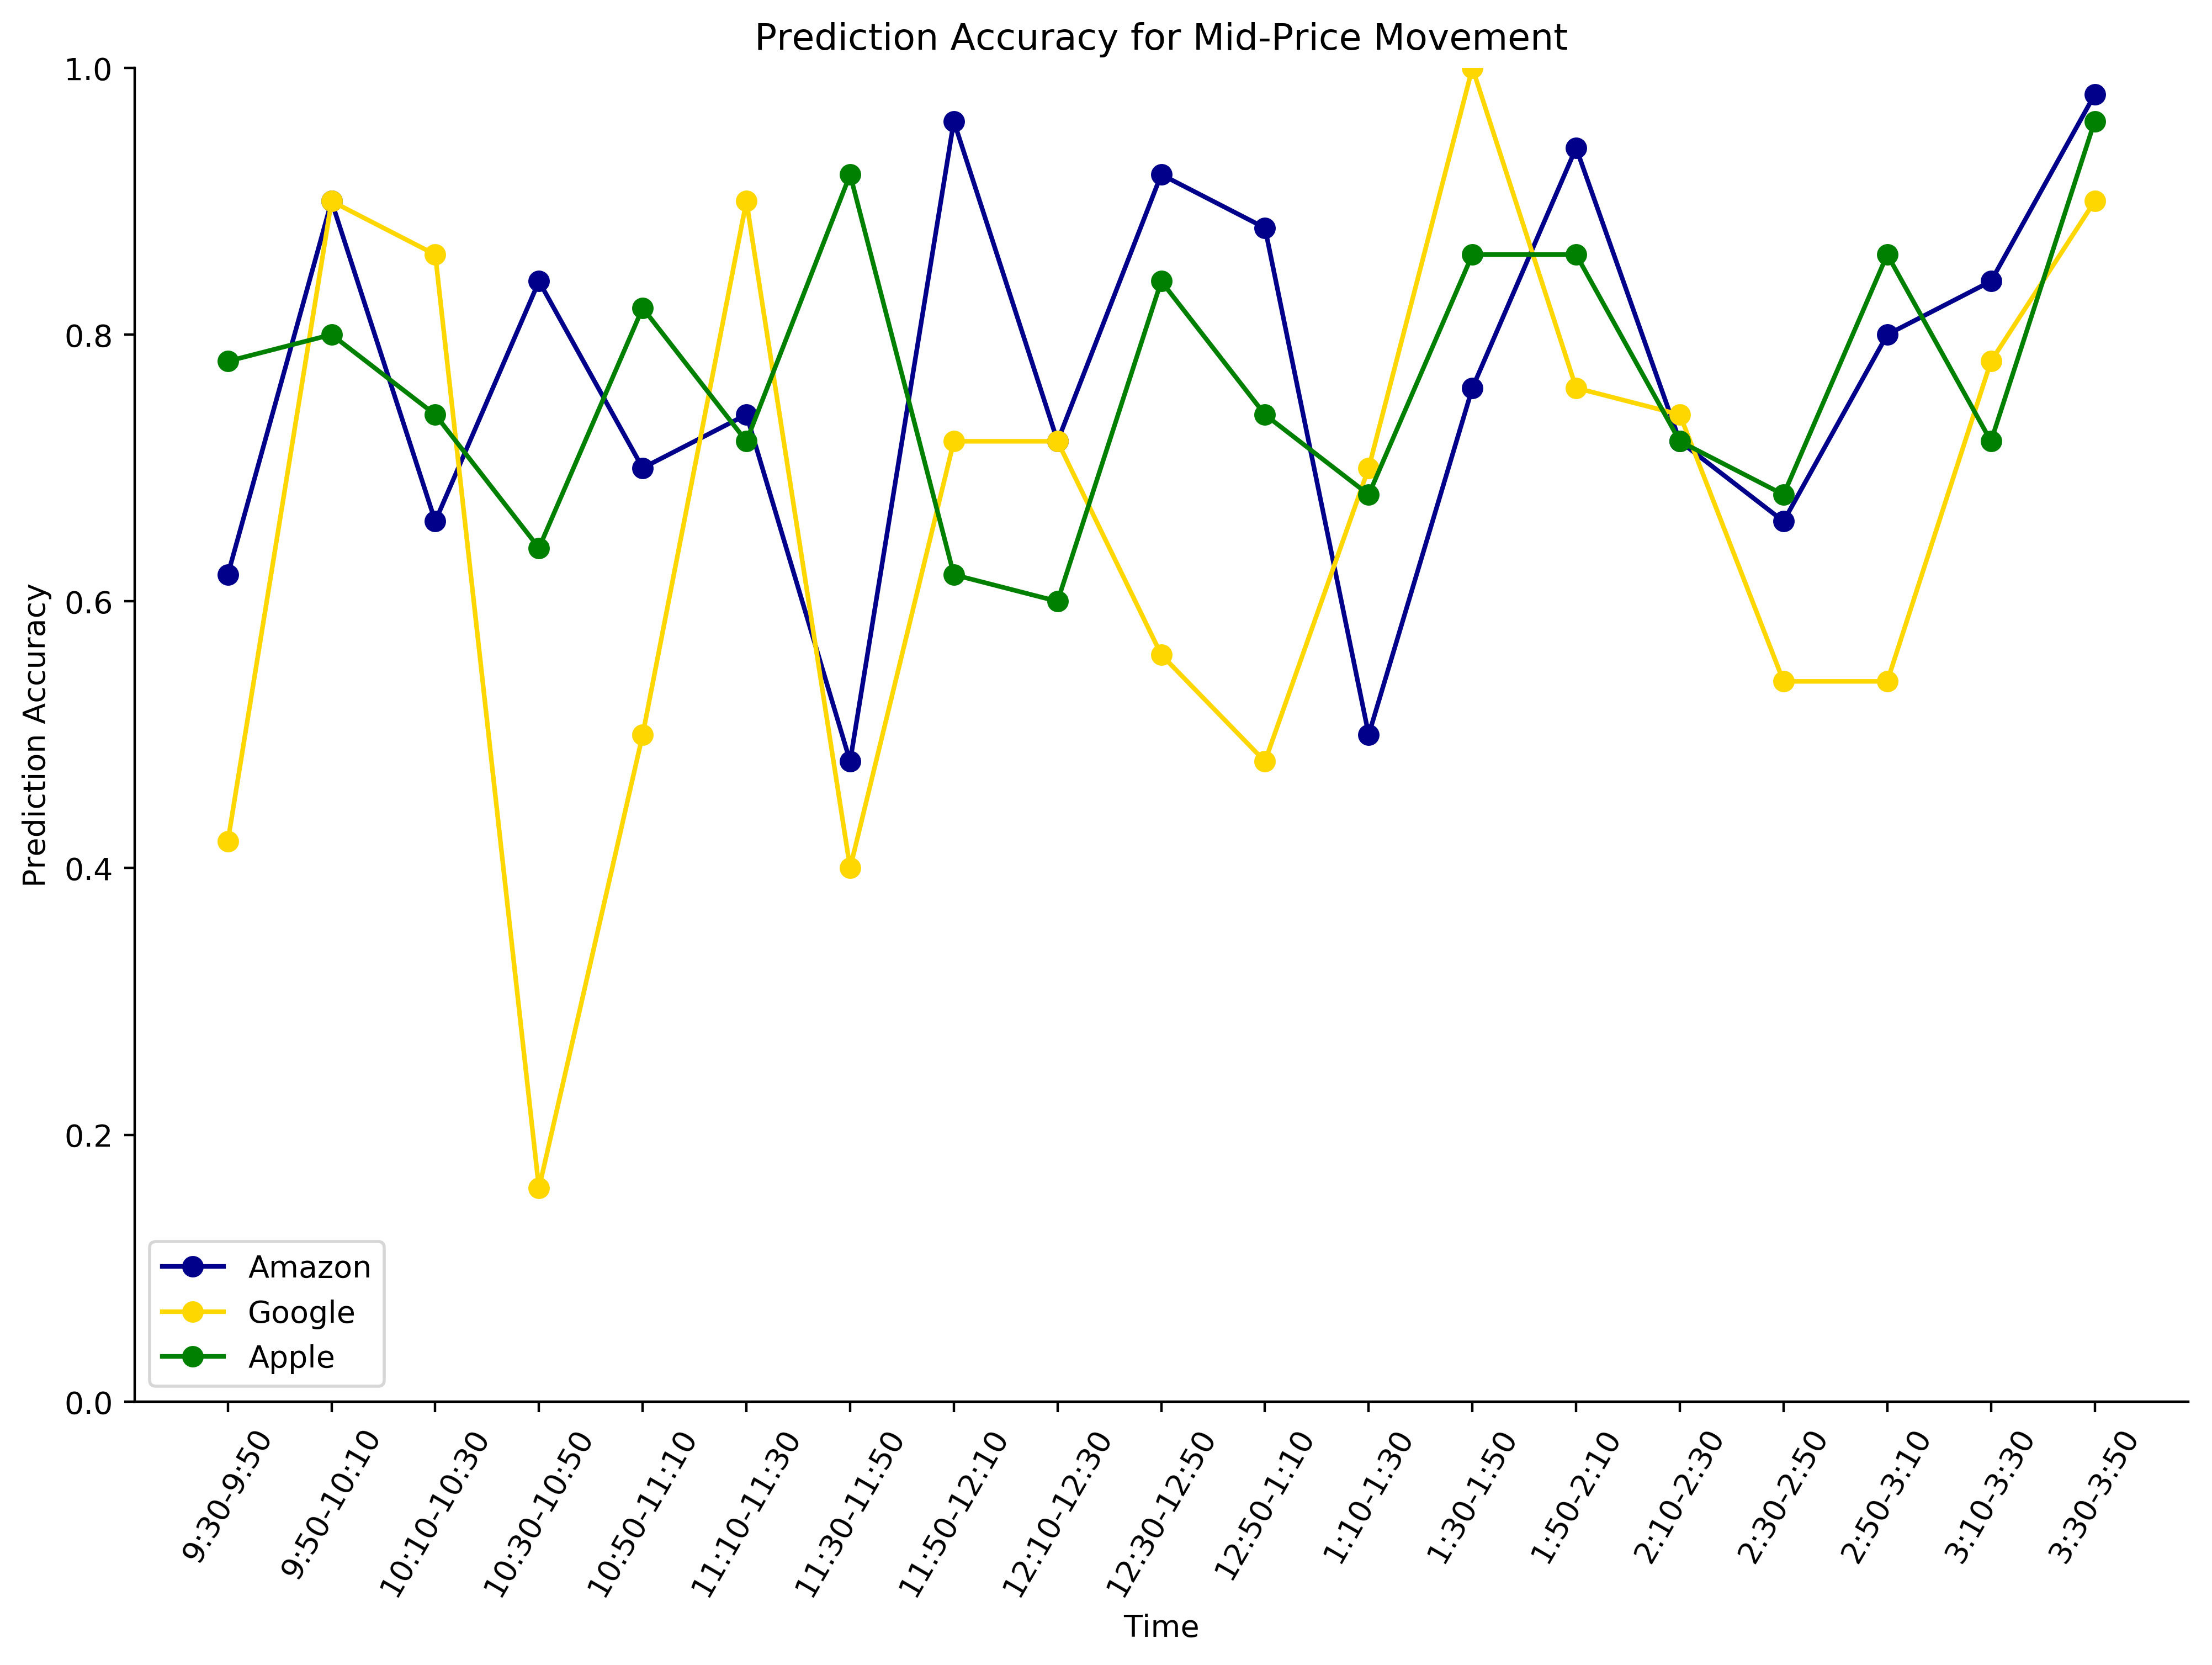

In [23]:
### Make plots for visualization
fig,ax = plt.subplots(1,1,figsize=(12,8),dpi=400)

x = np.arange(len(times))
ax.plot(x,test_accs_AMZN,marker='o',color='darkblue',label='Amazon')
ax.plot(x,test_accs_GOOG,marker='o',color='gold',label='Google')
ax.plot(x,test_accs_AAPL,marker='o',color='green',label='Apple')

ax.legend(frameon=True)
ax.set_ylabel('Prediction Accuracy')
ax.set_xlabel('Time')
plt.title('Prediction Accuracy for Mid-Price Movement')

labels = times
plt.xticks(x,labels,rotation=60)

plt.ylim([0,1])
plt.show()